# Mood-RL Model Fitting
## Section 1: Motivating model parameterization  
### Explaining the "Matt trick"
To fit reinforcement learning models with Stan, we utilize non-centered parameterizations (aka the "Matt trick"). This parameterization improves the efficiency of MCMC sampling by making the sampling space uniformly dense. Traditionally in Bayesian modeling, the inverse temperature ($\beta$) and learning rate ($\eta$) are sampled from directly (often with non-informative uniform priors). We will instead employ a two-step procedure where we will first sample from independent unit normal priors and then transform the samples into their appropriate parameter spaces:

> $\beta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta = C \cdot \text{Phi_approx}(\beta_{pr})$

> $\eta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta = \text{Phi_approx}(\eta_{pr}) $

where *Phi_approx* is a fast approximation of the cumulative unit normal [(Bowling et al., 2009)](http://www.jiem.org/index.php/jiem/article/view/60):

> $\text{Phi_approx}(x) = \text{logit}^{-1}(0.07056 \ x^3 + 1.5976 \ x) $

As an approximation of the cumulative unit normal, the *Phi_approx* function conveniently scales its inputs to be in the range $x \in (0, 1)$. As such, samples from $\eta_{pr}$ are of appropriate scale following transformation. Because values of $\beta$ are normally much larger than 1, a scaling function, $C$, is used to scale the samples of $\beta_{pr}$ to an appropriate range. For example, a user would set $C=20$ to sample $\beta \in (0,20)$.

For details, see the [Stan users manual](http://mc-stan.org/users/documentation/) (section 28.6). The [*hBayesDM*](https://github.com/CCS-Lab/hBayesDM) and [*fitr*](https://github.com/abrahamnunes/fitr) packages provided the templates for fitting these models.

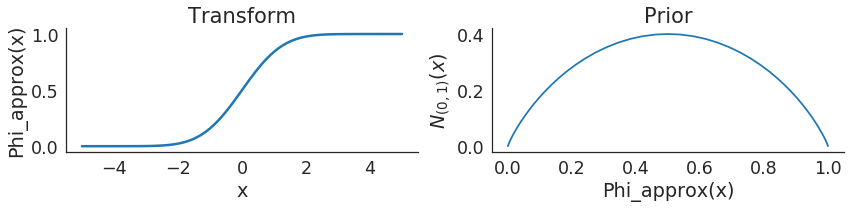

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import norm
from scripts.utilities import phi_approx
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,3))
x = np.linspace(-5,5,101)

## Plot Phi_approx function.
axes[0].plot(x, phi_approx(x), lw=2.5)
axes[0].set(xlabel='x', ylabel='Phi_approx(x)', title='Transform')

## Plot prior.
axes[1].plot(phi_approx(x), norm(0,1).pdf(x))
axes[1].set(xlabel='Phi_approx(x)', ylabel=r'$N_{(0,1)}(x)$', title='Prior')

sns.despine()
plt.tight_layout()

**Figure 1:** Visualizing the *Phi_approx* function. (Left) The transformation of arbitrary values, $x$, through *Phi_approx*. (Right) The probability density of *Phi_approx* scaled values, $x$, sampled from a unit normal distribution.

### Hierarchical parameterization
Non-centered parameterizations are especially useful for hierarchical models, where parameters may vary dramatically in scale (resulting in sampling issues). As such, all subject parameters are similarly sampled from a unit normal prior and transformed. To make the model hierarchical, i.e. to enforce partial pooling, subject-level parameters ($\beta_i, \eta_i$) are estimated using a similar two-step procedure:

> $\beta_{pr, i} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta_i = C \cdot \text{Phi_approx}(\beta_{pr,\mu} + \sigma_{\beta} \cdot \beta_{pr,i})$

> $\eta_{pr,i} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta_i = \text{Phi_approx}(\eta_{pr,\mu} + \sigma_{\eta} \cdot \eta_{pr,i}) $

where $\beta_{pr,\mu}$ and $\eta_{pr,\mu}$ are the group-level inverse temperature and learning rates, respectively; and $\sigma$ captures the variance of the subject-level parameters around the group mean. As above, the group-level parameters are also sampled through a unit normal prior. The variances can be sampled through a half-cauchy distribution or gamma distribution.  

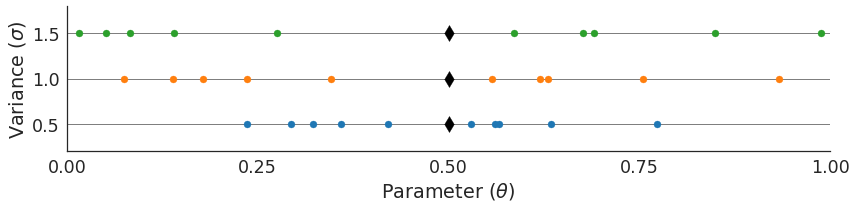

In [2]:
## Randomly generate arbitrary subject-level parameters.
np.random.seed(47404)
theta = np.random.normal(0,1,10)
sigma = [0.5,1,1.5]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
for s in sigma:
    ax.scatter(phi_approx(0 + s * theta), np.ones_like(theta)*s)
ax.scatter(phi_approx(np.zeros(3)), [0.5,1,1.5], s=130, marker='d', color='k')
    
## Add info.
ax.hlines(sigma, 0, 1, lw=0.5, zorder=0)
ax.set(xlim=(0,1), xticks=np.linspace(0,1,5), xlabel=r'Parameter ($\theta$)', 
       ylim=(0.2, 1.8), yticks=sigma, ylabel=r'Variance ($\sigma$)')
    
sns.despine()
plt.tight_layout()

**Figure 2:** Visualizing the hierarchical model. Arbitrarily sampled subject-level variables, $\theta_i$ (color circles), are distributed around a group-level variable, $\theta_\mu$ (diamonds). The variance of their distribution is dictated by $\sigma$. When $\sigma < 1$, the subject-level parameters shrink towards group-level value; when $\sigma > 1$, the subject-level parameters move away from group-level value.

### Prior on the mood-bias parameter ($f$) 

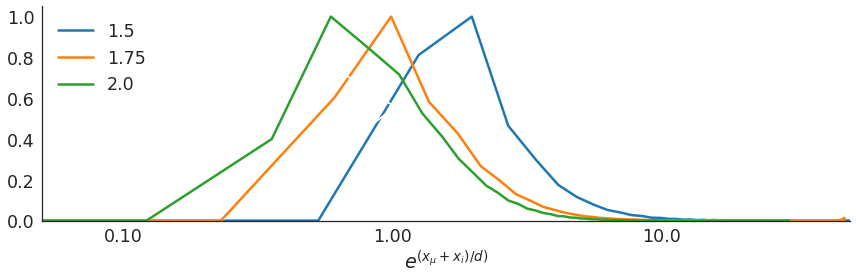

In [3]:
np.random.seed(47404)

## Simulate data.
f_pr = np.random.multivariate_normal(np.zeros(2), np.identity(2), int(1e6))
divisor = [1.5, 1.75, 2.0]

fig, ax = plt.subplots(1,1,figsize=(12,4))
for d in divisor:
    
    ## Compute f (assumings sigma = 1).
    f = np.exp( np.sum(f_pr, axis=1) / d )
    
    ## Plot.
    sns.kdeplot(f, color='w', ax=ax)
    line = ax.lines[-1]
    xdata, ydata = line.get_xdata(), line.get_ydata()
    ax.plot(xdata, ydata/ydata.max(), lw=2.5, label=d)
    
ax.set_xscale('log')
ax.set(xlim=(0.05, 50), xticks=np.logspace(-1,2,4), xlabel=r'$e^{(x_\mu + x_i)/d)}$', 
       ylim=(0,1.05), xticklabels=['0.10','1.00','10.0','100.'])
ax.legend(loc=2)
sns.despine()
plt.tight_layout()

## Section 2: Model fitting
The following block of code is used to fit the Stan models found in the *stan_models* directory. The models are parameterized to receive the same inputs as specified below. 

Importantly, all models were run with the same sampling parameters (i.e. 1250 steps with 1000 step burn-in and 4 chains) EXCEPT for the following models:
- **Dual:** 2250 samples, 2000 warmup
- **Orig:** 5250 samples, 5000 warmup

In [4]:
import os, pystan
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import check_div, check_energy, check_treedepth
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 1250
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Define metadata.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()
dt = data.Datetime.unique()

## Extract and prepare task data.
X = data[['M1','M2']].values.reshape(N,B,T,2)
Y = data.Choice.values.reshape(N,B,T,1)
Y = np.where( np.any(np.equal(X, Y), axis=-1), np.argmax(np.equal(X, Y), axis=-1) + 1, -1 )
R = data.Outcome.values.reshape(N,B,T)
R = np.where(R > 0, 1, 0)

## Extract and prepare mood data.
M = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(N,B,3) / 4

h12 = ratings.loc[ratings.Trial==0, 'Rating'].values.reshape(N,2) / 4
h12 = np.where(h12==-1, -0.99, np.where(h12==1, 0.99, h12))
h12 = np.arctanh(h12)

## Extract and prepare WoF data.
WoF = np.sign(metadata.WoF.values) * 28

## Organize data dictionary.
dd = dict(N=N, B=B, T=T, X=X, Y=Y, R=R, M=M, h12=h12, WoF=WoF)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Define control parameters.
    if 'orig' in model_name: control = dict(adapt_delta = 0.9)
    else: control = None
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, 
                      chains=chains, control=control, n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as f: cPickle.dump(extract, f)
        
    print('Done.')

<IPython.core.display.Javascript object>

## Model Comparisons
In this next section, we conduct model comparisons for the series of models fitted above. To do so, employ the widely applicable information criterion (WAIC; [Watanabe, 2010](http://www.jmlr.org/papers/volume11/watanabe10a/watanabe10a.pdf); [Gelman et al., 2014](https://link.springer.com/article/10.1007/s11222-013-9416-2); [Vehtari et al., 2017](https://link.springer.com/article/10.1007/s11222-016-9696-4)). The WAIC is a model performance metric that takes into consideration the entire posterior distribution. The WAIC is defined as:

> $\text{elppd}_{\text{waic}} = \text{lppd} - \text{pWAIC} $

where *elppd* is the expected log pointwise predictive density; *lppd* is the log pointwise predictive density; and pWAIC is a bias correction term. Conceptually, the WAIC is similar to the AIC or BIC in that the first term represents the goodness-of-fit of the model and the second term penalizes for model complexity. The WAIC differs, as mentioned above, in that it takes into consideration the full posterior density. For a set of $i \in N$ total observations, $y$, and $s \in S$ total posterior samples, $\theta$, the terms are computed as:

> $\text{lppd} = \sum \text{log} \ ( \frac{1}{S} \sum p(y_i \ | \ \theta^s)) $

> $\text{pWAIC} = \sum \text{Var} \ (\text{log} \ p(y_i \ | \ \theta^s))$

Briefly, it is worth mentioning that some have called for using alternatives performance metrics other than the WAIC (e.g. CV-LOO; [Gelman et al., 2014](https://link.springer.com/article/10.1007/s11222-013-9416-2); [Vehtari et al., 2017](https://link.springer.com/article/10.1007/s11222-016-9696-4)). As has been reported elsewhere (and observed in testing with these data), the WAIC and CV-LOO yield comparable estimates for data with many observations ([Watanabe, 2010](http://www.jmlr.org/papers/volume11/watanabe10a/watanabe10a.pdf); [Gelman et al., 2014](https://link.springer.com/article/10.1007/s11222-013-9416-2)). As such we use the more familiar WAIC metric.

### No-pooling vs. partial-pooling
In this first comparison, we test to see if hierarchically modeling participants' behavior improves model estimates. Previous work has shown that partial-pooling of data can improve model fitting and parameter recovery ([Gelman et al., 2013](http://www.stat.columbia.edu/~gelman/book/); [Kruschke, 2014](https://www.elsevier.com/books/doing-bayesian-data-analysis/kruschke/978-0-12-405888-0); [Lee & Wagenmakers, 2014](https://bayesmodels.com/)). Insofar that reinforcement learning models often suffer from identifiability issues ([Daw, 2011](http://www.cns.nyu.edu/~daw/d10.pdf); [Gershman, 2016](http://www.sciencedirect.com/science/article/pii/S0022249616000080)), hierarchical modeling may improve model estimation here.  

The two models compared below are the *no pooling* and *partial-pooling* baseline models. The baseline models represent the canonical Q-learning reinforcement learning models with two parameters (inverse temperature, $\beta$, and learning rate, $\eta_v$). The models differ only in that, in the partial-pooling model, each subject-level parameter ($\beta_i$, $\eta_i$) is assumed to be drawn from a normally distributed group-level parameter ($\beta_\mu$, $\eta_\mu$). 

In addition, these models assume that moods are variable-across/fixed-within subjects, such that for subject $i$ and trial $j$:

> $m_{ij}$ ~ $\mathcal{N}(\mu_i, \sigma)$


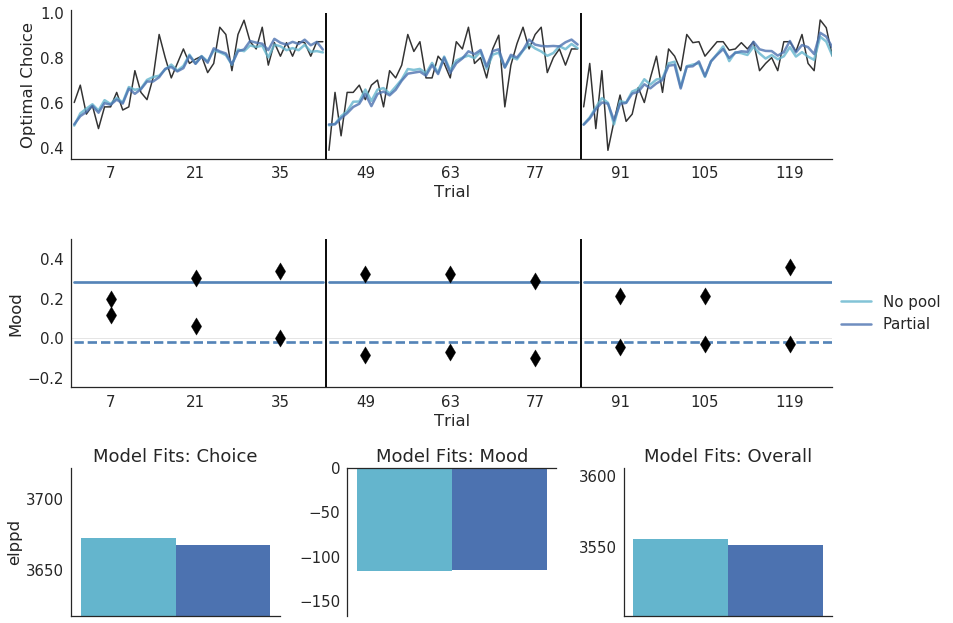

In [5]:
from scripts.plotting import plot_group_comparison
from scripts.utilities import model_comparison

## Define Stan models.
model_names = ['moodRL_npool_base', 'moodRL_ppool_base']
labels = ['No pool','Partial']
palette = ['#64b5cd','#4c72b0']

## Plot models.
fig, axes = plot_group_comparison(model_names, labels, palette=palette);
axes[1].set(ylim=(-0.25,0.50))
axes[1].legend(loc=7, bbox_to_anchor=(1.16,0.5))
sns.despine(bottom=True, top=False, ax=axes[-2])

The plot above shows very similar performance for the no pool and partially-pooled models. Formally, we compare the models below:

In [6]:
## Compute model comparison.
model_comparison(*model_names, verbose=True);

Model comparison
----------------
WAIC[1] = 3555
WAIC[2] = 3551
Diff	= 3.89 (14.12)


Though the difference in WAIC scores suggest a modest improvement with hierarchical pooling ($\Delta_\text{WAIC} = 3.89$), the standard error of the difference is substantially larger than the difference itself. The SE suggests that the improvement is weak at best. Hierarchical modeling maybe improves estimation here, but clearly not dramatically. (Parameter recovery might better demonstrate the benefits of partial pooling in this context.) Nevertheless, we continue with the partial-pooling model as baseline since the evidence weakly points towards it.

### Mood Models
Next we compare the various mood models. These include:
- **Baseline**: two parameter RL model ($\beta$, $\eta_v$) + 1 ($\mu_m$)
    - Mood modeled as above.
    
    
- **Mood** ($f=1$): three parameter RL model ($\beta$, $\eta_v$, $\eta_h$)
    - Mood modeled as history of RPEs ($\eta_h$)
    - Mood bias held contanst ($f=1$)
    
    
- **Mood** ($h$ fix): four parameter RL model ($\beta$, $\eta_v$, $\eta_h$, $f$)
    - Mood modeled as history of RPEs ($\eta_h$)
    - Mood bias variable. $h$ fixed to pre-block mood questionnaire responses.
    
    
- **Mood** ($h$ estimated): four parameter RL model ($\beta$, $\eta_v$, $\eta_h$, $f$)
    - Mood modeled as history of RPEs ($\eta_h$)
    - Mood bias variable. $h$ initialized at 0 and estimated directly from data. 
    
All models were estimated with partial-pooling. 

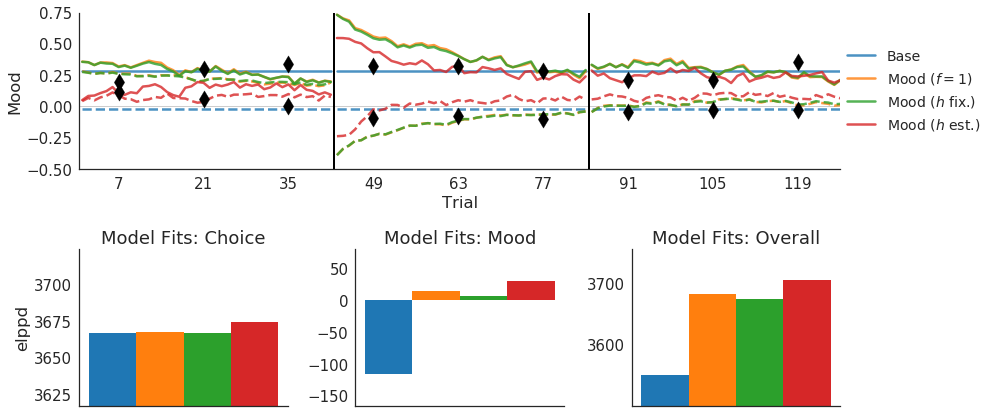

In [7]:
## Define Stan models.
model_names = ['moodRL_ppool_base', 'moodRL_ppool_mood', 
               'moodRL_ppool_mood_bias_mod', 'moodRL_ppool_mood_bias_orig']
labels = [r'Base', r'Mood ($f=1$)', r'Mood ($h$ fix.)', r'Mood ($h$ est.)']
palette = sns.color_palette(n_colors=4)

## Plot models.
fig, axes = plot_group_comparison(model_names, labels, palette=palette, show_behavior=False);
axes[0].set(ylim=(-0.5,0.75));
axes[0].legend(loc=7, bbox_to_anchor=(1.2,0.5), fontsize=14);

In the plots above, the posterior predictive check for choice is hidden as all models make near-identical predictions. The group-averaged posterior predictive check for mood, however, shows more variability. As is expected, the baseline model (blue) exhibits constant mood. The fixed bias and $h$-fixed models (yellow, green) make similar mood predictions. 

The WAIC shows that the models perform similarly on choice (though perhaps $h$-estimated performs worse). In contrast, the baseline model qualitatively performs much better than the other models in predicting mood, leading to an overall lowest deviance.

In [8]:
## Compute model comparison.
model_comparison('moodRL_ppool_base', 'moodRL_ppool_mood_bias_mod', verbose=True);

Model comparison
----------------
WAIC[1] = 3551
WAIC[2] = 3674
Diff	= -122.93 (33.45)


In [9]:
## Compute model comparison.
model_comparison('moodRL_ppool_mood_bias_mod', 'moodRL_ppool_mood', verbose=True);

Model comparison
----------------
WAIC[1] = 3674
WAIC[2] = 3682
Diff	= -8.11 (5.26)


In [10]:
## Compute model comparison.
model_comparison('moodRL_ppool_mood', 'moodRL_ppool_mood_bias_orig', verbose=True);

Model comparison
----------------
WAIC[1] = 3682
WAIC[2] = 3704
Diff	= -21.89 (31.26)


Formal model comparison reveals the following order of models:

> baseline > mood ($h$-fixed) > mood ($f=1$) = mood ($h$-estimated)

### Comparing model parameters

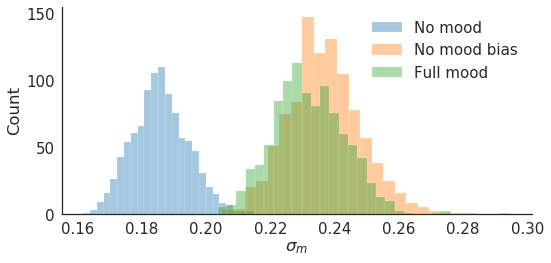

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

f = 'stan_fits/moodRL_ppool_base/StanFit.pickle'
with open(f, 'rb') as f: fit1 = cPickle.load(f)
    
## Load mood StanFit file.
f = 'stan_fits/moodRL_ppool_mood/StanFit.pickle'
with open(f, 'rb') as f: fit2 = cPickle.load(f)
    
## Load mood bias (mod) StanFit file.
f = 'stan_fits/moodRL_ppool_mood_bias_mod/StanFit.pickle'
with open(f, 'rb') as f: fit3 = cPickle.load(f)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))
labels = ['No mood', r'No mood bias', 'Full mood']
colors = sns.color_palette(n_colors=3)

## Plot.
for fit, color, label in zip([fit1,fit2,fit3], colors, labels):
    sns.distplot(fit['sigma_m'], bins=25, kde=False, color=color, label=label,
                 hist_kws=dict(edgecolor='w'), ax=ax)

ax.set(xlabel=r'$\sigma_m$', ylabel='Count')
ax.legend(loc=1)
sns.despine()
plt.tight_layout()

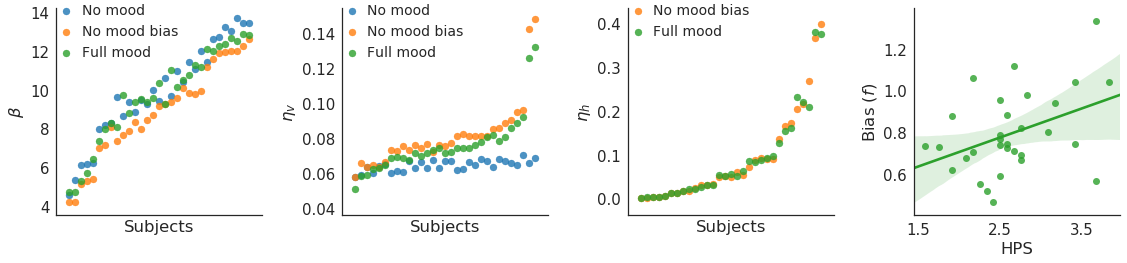

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(16,4))
labels = ['No mood', r'No mood bias', 'Full mood']
colors = sns.color_palette(n_colors=3)

for ax, param in zip(axes, ['beta','eta_v','eta_h']):
    
    ## Assemble data. Sort.
    points = np.array([ np.median(fit[param], axis=0) for fit in [fit1,fit2,fit3] if param in fit.keys() ])
    sort_ix = np.argsort(points.mean(axis=0))
    
    ## Plot.
    for arr, color, label in zip(points, colors[-points.shape[0]:], labels[-points.shape[0]:]):
        
        ax.scatter(np.arange(sort_ix.size), arr[sort_ix], label=label, color=color, alpha=0.8)
    
    ## Add info.
    ax.set(xticks=[], xlabel='Subjects', ylabel=r'$\%s$' %param)
    ax.legend(loc=2, borderpad=-0.8, handletextpad=0.1, fontsize=14)
    
## Plot f.
sns.regplot(metadata.IPIP_hps, np.median(fit3['f'], axis=0), color=colors[-1], ax=axes[-1])
axes[3].set(xlabel='HPS', xticks=np.arange(1.5,4,1), ylabel=r'Bias ($f$)')
    
sns.despine()
plt.tight_layout()

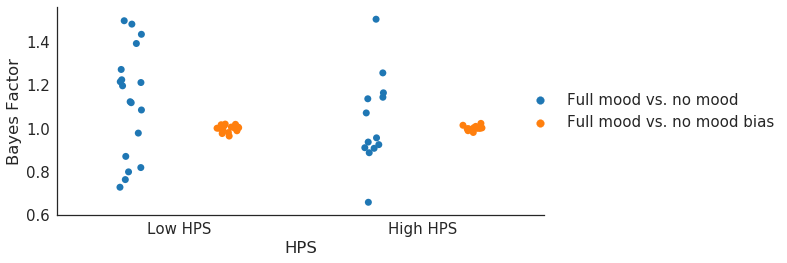

In [13]:
def zscore(arr):
    return (arr - arr.mean()) / arr.std()

def normal_lpdf(x, mu, sd):
    return -0.5 * np.log(2*np.pi) - 0.5 * np.log(sd**2) - 0.5 * (sd**-2) * (x - mu)**2

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

log_lik = []
for fit in [fit1, fit2, fit3]:
    
    ## Extract data.
    M_obs = fit['M'].copy()
    h_pred = fit['h_pred'].copy()
    M_pred = np.tanh(h_pred[...,[6,20,34]])
    
    ## Reshape data.
    n_samp, n_subj, n_block, n_trial = M_pred.shape
    M_obs = M_obs.reshape(n_subj, n_block*n_trial)
    M_pred = M_pred.reshape(n_samp, n_subj, n_block*n_trial)
    
    ## Z-score. Mask NaNs.
    M_obs = np.apply_along_axis(zscore, -1, M_obs)
    M_obs = np.where(np.isnan(M_obs), 0, M_obs)
    M_pred = np.apply_along_axis(zscore, -1, M_pred)
    M_pred = np.where(np.isnan(M_pred), 0, M_pred)
    
    ## Compute log-likelihood.
    lpdf = np.array([normal_lpdf(M_obs, mu, 1) for mu in M_pred])
    
    ## Append.
    log_lik.append( np.apply_over_axes(np.sum, lpdf, [0,2]).squeeze() )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Convert Bayes factors to DataFrame.
df = DataFrame(np.vstack([log_lik[2]/log_lik[0], log_lik[2]/log_lik[1]]).T,
               columns=('Full mood vs. no mood', 'Full mood vs. no mood bias') )
df['HPS'] = np.where(metadata.IPIP_hps > metadata.IPIP_hps.mean(), 'High HPS', 'Low HPS')
df = df.melt(id_vars='HPS', var_name='Model', value_name='Bayes Factor')

## Plot.
sns.stripplot('HPS', 'Bayes Factor', 'Model', data=df, size=7, dodge=True, jitter=True, ax=ax)
ax.legend(loc=7, bbox_to_anchor=(1.5,0.5))

sns.despine()
plt.tight_layout()